<img src='logo.png' align='center'>
<div align='center' class="h2">深度学习理论与实践编程练习(Course 02)</div>

-----
### 命名格式：按照课程网站中的课后作业要求
-----

#### 1. 根据Course02课程中对全连接神经网络的讲解，将缺失的全连接神经网络中代码块补全，并完成一次训练
    需要填充的部分已经在第一部分的全连接神经网络代码中用红色的"""补全代码"""标示
    
    
#### 2. 利用sklearn的指标评测函数得出模型在测试集上的性能
    从sklearn官网上查找metrics子包中关于评价指标的计算函数，了解其用法，之后的课程中就用到。
-----

【目录】

<a href="#1.-手写数字识别数据集(MNIST)">1. 手写数字识别数据集（MNIST）</a>

<a href="#2.-全连接神经网络(Full-Connected-Neural-Network)" >2. 全连接神经网络</a>



----
## 1. 手写数字识别数据集(MNIST)

In [102]:
## 引入python包，没有安装的请按照抛出的error通过conda来安装直至成功
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import sklearn
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import _pickle as cPickle
import gzip
import random

In [103]:
#  载入mnist数据
def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('MNIST/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = cPickle.load(f, encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

def minist_loader():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    # cause the network's input is a vector 784X1, so we reshape the image so as to more convenient
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))

    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))

    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [104]:
training_data, validation_data, test_data = minist_loader()


In [105]:
print(len(training_data[0][0]))
print(training_data[0][1])


784
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [106]:
print(training_data[1][1])

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [107]:
print(test_data[0][1])

7


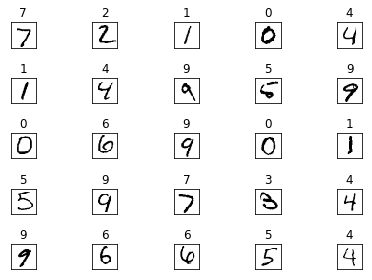

In [108]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex='all', sharey='all')
ax = ax.flatten()
for i in range(25):
    ax[i].set_title(int(test_data[i][1]))
    img = test_data[i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [109]:
print("训练集个数：{} 验证集个数：{} 测试集个数：{}".format(len(training_data), len(validation_data), len(test_data)))

训练集个数：50000 验证集个数：10000 测试集个数：10000


----

## 2. 全连接神经网络(Full Connected Neural Network)
全连神经网络从前向后分为`输入层` -> `隐藏层`xM -> `输出层`。如果网络共有N层的话，那么存在N-1个权重连接矩阵和N-1个对应的偏置向量，其维度分别为:

$$
\large
W^{l_i} \in R^{l_i \times l_{i-1}} \quad (1<l_i \leq N)
$$

$$
\large
b^{l_i} \in R^{l_i } \quad (1 < l_i \leq N) 
$$

<!-- <img src="FCNN.png" width="40%" align="center"> -->


全连接神经网络的构建分为前向传播和误差的反向传播，具体的过程如下图：
<img src='BP.png' align='center'>

In [110]:

def sigmoid(z):
    """
    Sigmoid激活函数定义
    """
    return 1 / (1 + np.exp(-z))
    """补全代码"""

def sigmoid_prime(z):
    """
    Sigmoid函数的导数,关于Sigmoid函数的求导可以自行搜索。
    """
    """补全代码"""
    return sigmoid(z) * (1-sigmoid(z))

In [126]:
def test_func(a):
    b = 1
    a = a + b
    return a

In [127]:
a = 10
test_func(a)
print(a)

10


In [122]:
# Full Connected Network
class FCN(object):
    """
    全连接网络的纯手工实现
    """
    def __init__(self, sizes):
        """
        :param sizes: 是一个列表，其中包含了神经网络每一层的神经元的个数，列表的长度就是神经网络的层数。
        举个例子，假如列表为[784,30,10]，那么意味着它是一个3层的神经网络，第一层包含784个神经元，第二层30个，最后一层10个。
        注意，神经网络的权重和偏置是随机生成的，使用一个均值为0，方差为1的高斯分布。
        注意第一层被认为是输入层，它是没有偏置向量b和权重向量w的。因为偏置只是用来计算第二层之后的输出
        """
        self._num_layers = len(sizes) # 记录神经网络的层数
        # 为隐藏层和输出层生成偏置向量b，还是以[784,30,10]为例，那么一共会生成2个偏置向量b，分别属于隐藏层和输出层，大小分别为30x1,10x1。
        """补全代码"""
        self._biases = [np.random.randn(i,1) for i in sizes[1:]]
        # 为隐藏层和输出层生成权重向量W, 以[784,30,10]为例，这里会生成2个权重向量w，分别属于隐藏层和输出层，大小分别是30x784, 10x30。
        """补全代码"""
        self._weights = [np.random.randn(i,j) for i,j in zip(sizes[1:],sizes[:-1])]
        print("Finish constructing obj FCN")
    def feedforward(self, a):
        """
        前向计算，返回神经网络的输出。公式如下:
        output = sigmoid(w*x+b)
        以[784,30,10]为例，权重向量大小分别为[30x784, 10x30]，偏置向量大小分别为[30x1, 10x1]
        输入向量为 784x1.
        矩阵的计算过程为：
            30x784 * 784x1 = 30x1
            30x1 + 30x1 = 30x1

            10x30 * 30x1 = 10x1
            10x1 + 10x1 = 10x1
            故最后的输出是10x1的向量，即代表了10个数字。
        :param a: 神经网络的输入
        """
        for w, b in zip(self._weights, self._biases):
            z = np.dot(w, a) + b
            a = sigmoid(z)
        return a

    def train(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        """
        使用小批量随机梯度下降来训练网络
        :param training_data: training data 是一个元素为(x, y)元祖形式的列表，代表了训练数据的输入和输出。
        :param epochs: 训练轮次
        :param mini_batch_size: 小批量训练样本数据集大小
        :param eta: 学习率
        :param test_data: 如果test_data被指定，那么在每一轮迭代完成之后，都对测试数据集进行评估，计算有多少样本被正确识别了。但是这会拖慢训练速度。
        :return:
        """
        if test_data: 
            n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            # 在每一次迭代之前，都将训练数据集进行随机打乱，然后每次随机选取若干个小批量训练数据集
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]

            # 每次训练迭代周期中要使用完全部的小批量训练数据集
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            # 如果test_data被指定，那么在每一轮迭代完成之后，都对测试数据集进行评估，计算有多少样本被正确识别了
            if test_data:
                print("Epoch %d: accuracy rate: %.2f%%" % (j, self.evaluate(test_data)/n_test*100))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """
        通过小批量随机梯度下降以及反向传播来更新神经网络的权重和偏置向量
        :param mini_batch: 随机选择的小批量
        :param eta: 学习率
        """
        nabla_b = [np.zeros(b.shape) for b in self._biases]
        nabla_w = [np.zeros(w.shape) for w in self._weights]
        for x,y in mini_batch: # image,label
            # 反向传播算法，运用链式法则求得对b和w的偏导
            """补全代码"""
            delta_nabla_b, delta_nabla_w = self.backprop(x,y)
            # 对小批量训练数据集中的每一个求得的偏导数进行累加
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        # 使用梯度下降得出的规则来更新权重和偏置向量
        self._weights = [w - (eta / len(mini_batch)) * nw
                        for w, nw in zip(self._weights, nabla_w)]
        self._biases = [b - (eta / len(mini_batch)) * nb
                       for b, nb in zip(self._biases, nabla_b)]

    def backprop(self, x, y):
        """
        反向传播算法，计算损失对w和b的梯度
        :param x: 训练数据x
        :param y: 训练数据x对应的标签
        :return: Return a tuple ``(nabla_b, nabla_w)`` representing the
                gradient for the cost function C_x.  ``nabla_b`` and
                ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
                to ``self.biases`` and ``self.weights``.
        """
        nabla_b = [np.zeros(b.shape) for b in self._biases]
        nabla_w = [np.zeros(w.shape) for w in self._weights]
        # 前向传播，计算网络的输出
        activation = x
        # 一层一层存储全部激活值的列表
        activations = [x]
        # 一层一层存储全部的z向量，即带权输入
        zs = []
        for b, w in zip(self._biases, self._weights):
            # 利用 z = wt*x+b 依次计算网络的输出
            z = np.dot(w, activation) + b
            zs.append(z)
            # 将每个神经元的输出z通过激活函数sigmoid
            activation = sigmoid(z)
            # 将激活值放入列表中暂存
            activations.append(activation)
        
        # 反向传播过程

        # 首先计算输出层的误差delta L
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        # 反向存储 损失函数C对b的偏导数
        nabla_b[-1] = delta
        # 反向存储 损失函数C对w的偏导数
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # 从第二层开始，依次计算每一层的神经元的偏导数
        for l in range(2, self._num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            # 更新得到前一层的误差delta
            """补全代码"""
            delta = np.dot(self._weights[-l + 1].transpose(), delta) * sp
            # 保存损失喊出C对b的偏导数，它就等于误差delta
            nabla_b[-l] = delta
            # 计算损失函数C对w的偏导数
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        # 返回每一层神经元的对b和w的偏导数
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """
        返回神经网络对测试数据test_data的预测结果，并且计算其中识别正确的个数
        因为神经网络的输出是一个10x1的向量，我们需要知道哪一个神经元被激活的程度最大，
        因此使用了argmax函数以获取激活值最大的神经元的下标，那就是网络输出的最终结果。
        """
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """
        返回损失函数对a的的偏导数，损失函数定义 C = 1/2*||y(x)-a||^2
        求导的结果为：
            C' = y(x) - a
        """
        return (output_activations - y)

In [128]:
# 定义一个3层全连接网络，输入层有784个神经元，隐藏层30个神经元，输出层10个神经元
fc = FCN([784,1])
# 设置迭代次数40次，mini-batch大小为10，学习率为3，并且设置测试集，即每一轮训练完成之后，都对模型进行一次评估。
# 这里的参数可以根据实际情况进行修改
fc.train(training_data, 5, 128, 5.0, test_data=test_data)

Finish constructing obj FCN
Epoch 0: accuracy rate: 47.20%
Epoch 1: accuracy rate: 55.21%
Epoch 2: accuracy rate: 55.91%
Epoch 3: accuracy rate: 56.38%
Epoch 4: accuracy rate: 56.49%
